In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from utils import AreaEnergy, TSF

공대7호관_HV_02 = AreaEnergy('공대7호관.HV_02',
                         path_time=r"../dataset/Electricity data_CNU/3.unit of time(일보)/")

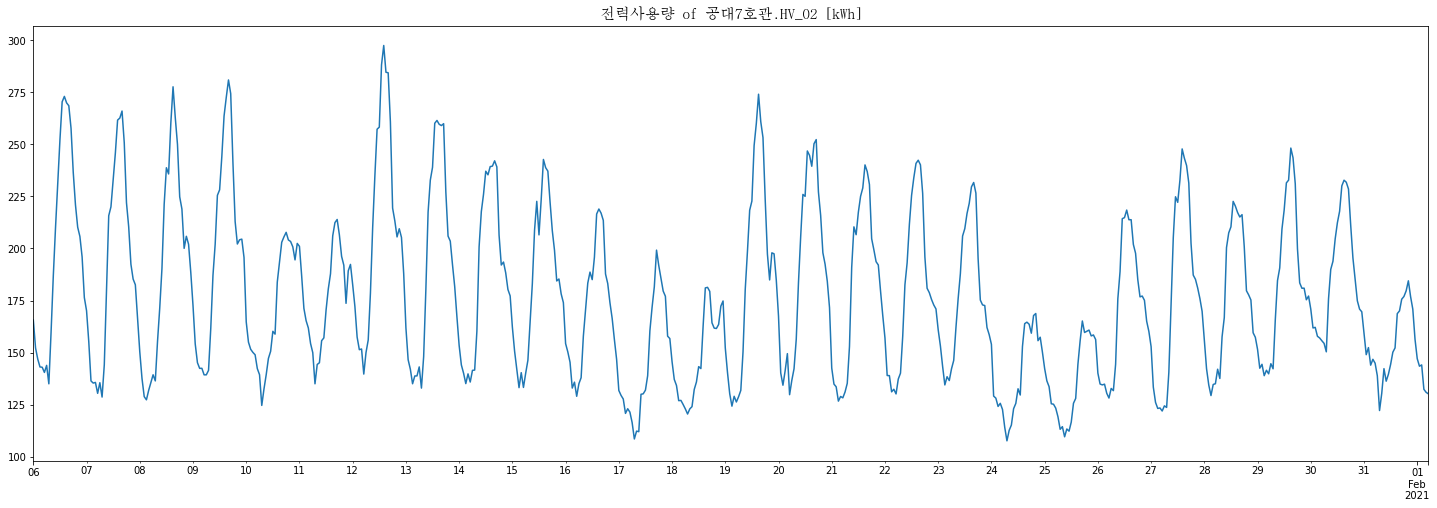

In [3]:
import matplotlib.font_manager as fm
path_pen = 'C:/Windows/Fonts/BatangChe.TTF'
font = fm.FontProperties(fname=path_pen, size=15)

df_seq = pd.DataFrame(공대7호관_HV_02.arr_seq_dataset, columns=['전력사용량'], index=공대7호관_HV_02.index_all_time)
fig, axs = plt.subplots(figsize=(25, 8))
plt.title('전력사용량 of ' + 공대7호관_HV_02.name_area + ' [kWh]', fontproperties=font)
plot_features = df_seq['전력사용량'][120:750]
plot_features.index = df_seq.index[120:750]
plt.rcParams["figure.dpi"] = 2000
_ = plot_features.plot(subplots=True)
plt.show()

C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


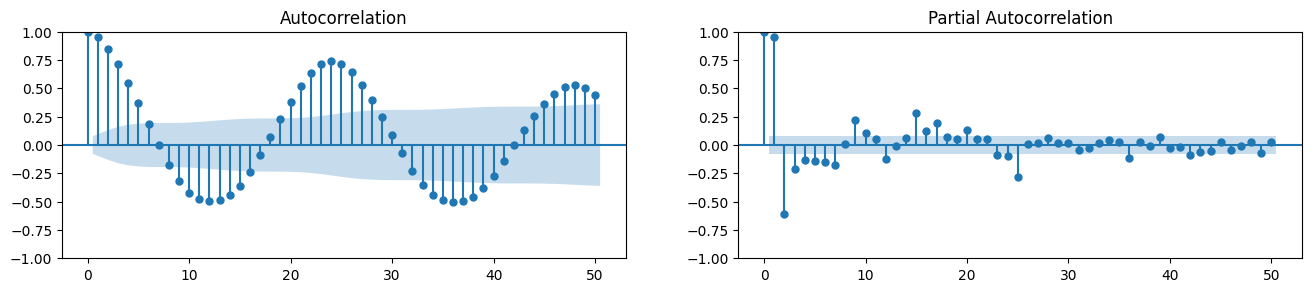

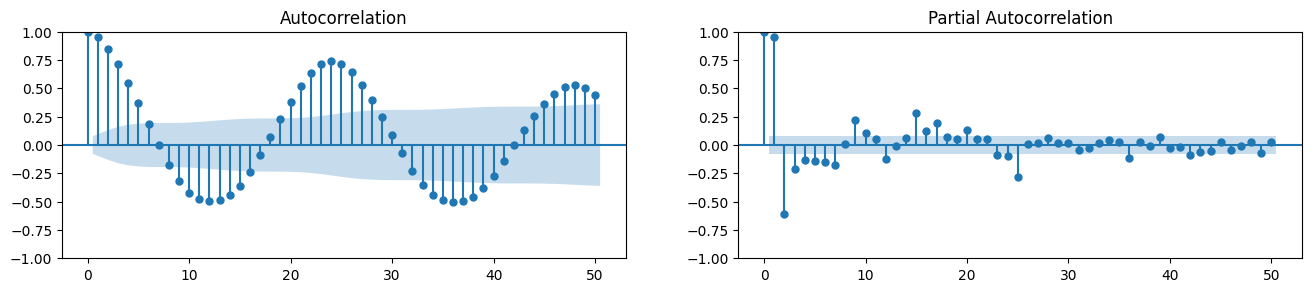

In [4]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(plot_features.tolist(), lags=50, ax=axes[0])
plot_pacf(plot_features.tolist(), lags=50, ax=axes[1])

C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.tight_layout()
C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.tight_layout()
C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.tight_layout()
C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.tight_layout()
C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.tight_layout()
C:\Users\Andrew\anaconda3\envs\kepco\lib\site-packages\IPyth

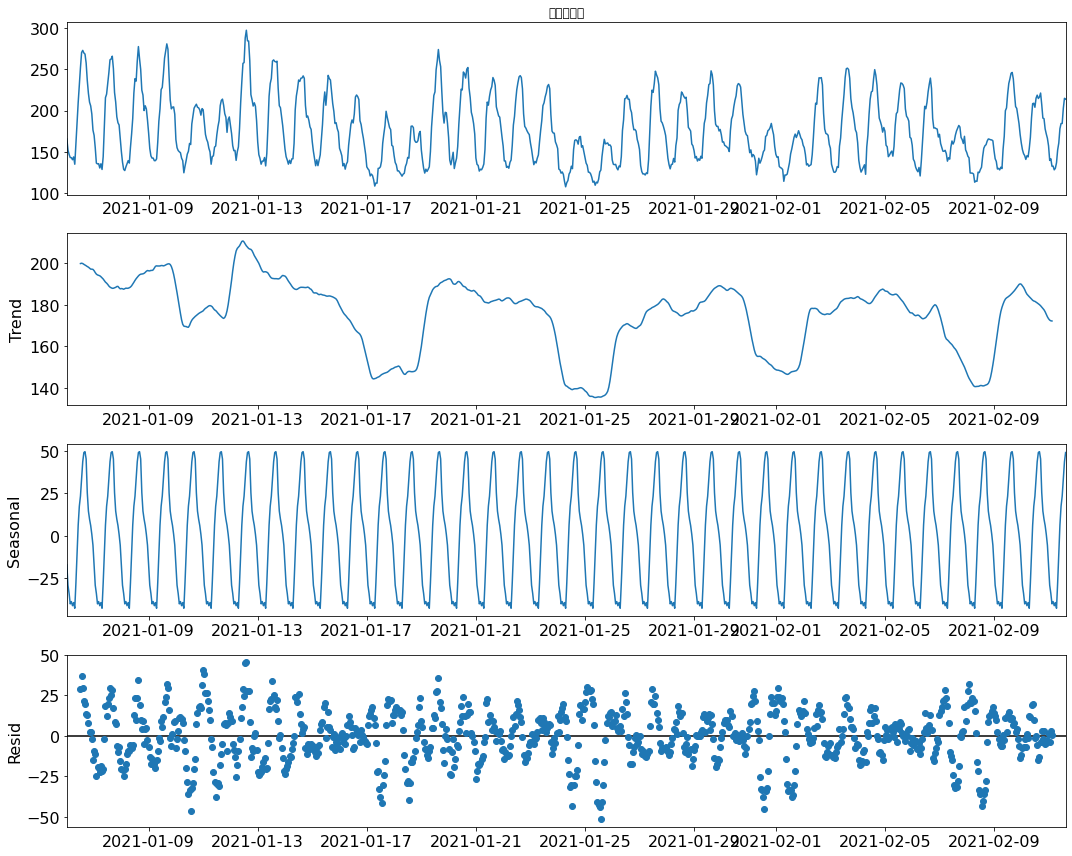

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_seq['전력사용량'][120:1000], model='additive')
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomp = decomposition.plot()
#
# decomp.suptitle('Energy consumption Decomposition', fontsize=22)

In [1]:
# input_width = 12
# label_width = 1
# num_features = 1

# tsf = TSF(공대7호관_HV_02.arr_seq_dataset, batch_size=32, shift=1, shuffle=False, input_width=input_width,
#           label_width=label_width)

In [ ]:
from utils import TSF_Data

tsf = TSF_Data(data=공대7호관_HV_02.arr_seq_dataset,
               input_width=700,
               output_width=24,
               train_ratio=0.9)

In [2]:
from utils import TSF_Data

tsf = TSF_Data(data=공대7호관_HV_02.arr_seq_dataset,
               input_width=700,
               output_width=24,
               train_ratio=0.9)

tsf.normalize_data()

In [3]:
print(tsf.data_train[0].shape)
print(tsf.data_train[1].shape)

(8373, 700, 1)
(8373, 24)


In [4]:
np.std(tsf.raw_data)

46.96696837808928

In [4]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input


input_width = tsf.data_train[0].shape[1]
num_features = 1

inputs = Input(shape=(input_width, num_features))

x1 = TCN(input_shape=(input_width, 1),
         kernel_size=7,
         nb_filters=128,
         dilations=(1,2,4,8),
         use_skip_connections=True,
         use_batch_norm=False,
         use_weight_norm=False,
         use_layer_norm=False
         )(inputs)

x2 = Dense(units=24, activation='linear')(x1)

model1 = Model(inputs, x2, name="single_tcn_output")

model1.summary()
model1.compile('adam', 'mae')

# from tensorflow import keras
# keras.utils.plot_model(model, "TCN on CNU.png",
#                         dpi=120,
#                         show_shapes=True,
#                         show_dtype=True,
#                         show_layer_names=True,
#                         rankdir='TB',
#                         expand_nested=True,
#                         show_layer_activations=True
#                         )
checkpoint_path = "CNU/one_output/cp.ckpt"
log_dir = "CNU/one_output/Tensorboard"

print('Train...')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1, patience=3, min_lr=0.00001, verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
)

callbacks = [
    early_stopping,
    reduceLR,
    tensorboard_callback
]

history = model1.fit(x=tsf.data_train[0],
                    y=tsf.data_train[1],
                    validation_data=tsf.data_valid,
                    epochs=50,
                    callbacks=[callbacks],
                    verbose=2,
                    use_multiprocessing=True)


Model: "single_tcn_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 tcn (TCN)                   (None, 128)               804992    
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 808,088
Trainable params: 808,088
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/50
262/262 - 8s - loss: 0.1113 - val_loss: 0.0810 - lr: 0.0010 - 8s/epoch - 30ms/step
Epoch 2/50
262/262 - 5s - loss: 0.0616 - val_loss: 0.0699 - lr: 0.0010 - 5s/epoch - 20ms/step
Epoch 3/50
262/262 - 5s - loss: 0.0588 - val_loss: 0.0670 - lr: 0.0010 - 5s/epoch - 20ms/step
Epoch 4/50
262/2

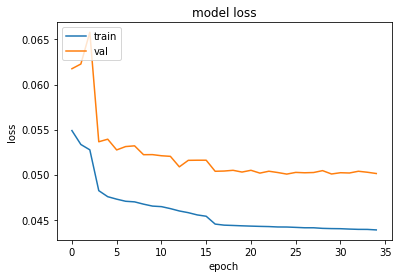

400/400 - 1s - loss: 0.0616 - 1s/epoch - 3ms/step


0.06162024661898613

In [5]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model1.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

In [6]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D


input_width = tsf.data_train[0].shape[1]
num_features = 1

inputs = Input(shape=(input_width, num_features))

x1 = TCN(input_shape=(input_width, 1),
         kernel_size=7,
         nb_filters=128,
         dilations=(1,2,4,8),
         use_skip_connections=True,
         use_batch_norm=False,
         use_weight_norm=False,
         use_layer_norm=False,
         return_sequences=True
         )(inputs)

x15 = Flatten()(x1)

x2 = Dense(units=24, activation='linear')(x15)

model = Model(inputs, x2, name="multi_tcn_output")

model.summary()
model.compile('adam', 'mae')


checkpoint_path = "CNU/multi_output/cp.ckpt"
log_dir = "CNU/multi_output/Tensorboard"

print('Train...')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.1, patience=3, min_lr=0.00001, verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
)

callbacks = [
    early_stopping,
    reduceLR,
    tensorboard_callback
]

history2 = model.fit(x=tsf.data_train[0],
                    y=tsf.data_train[1],
                    validation_data=tsf.data_valid,
                    epochs=50,
                    callbacks=[callbacks],
                    verbose=2,
                    use_multiprocessing=True)


Model: "multi_tcn_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 700, 1)]          0         
                                                                 
 tcn_1 (TCN)                 (None, 700, 128)          804992    
                                                                 
 flatten (Flatten)           (None, 89600)             0         
                                                                 
 dense_1 (Dense)             (None, 24)                2150424   
                                                                 
Total params: 2,955,416
Trainable params: 2,955,416
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/50
262/262 - 6s - loss: 1.0435 - val_loss: 0.0738 - lr: 0.0010 - 6s/epoch - 25ms/step
Epoch 2/50
262/262 - 5s - loss: 0.0635 - val_loss: 0.0596 - lr: 0.001

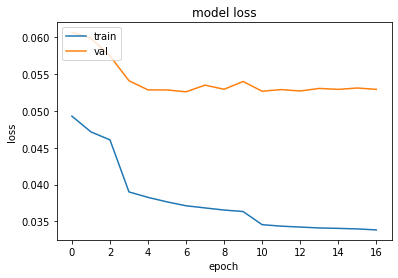

400/400 - 1s - loss: 0.0555 - 1s/epoch - 3ms/step


0.055474743247032166

In [7]:
# summarize history for loss
plt.plot(history2.history['loss'][5:])
plt.plot(history2.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

In [17]:
input_shape=(1, 24, 1)
test_input = np.arange(np.prod(input_shape)).reshape(input_shape)
output_shape = (1, 24)
test_output = np.arange(np.prod(output_shape)).reshape(output_shape)
# test_output.reshape(test_output.shape[0], 1, test_output.shape[1]).shape
model(test_input).shape

TensorShape([1, 24, 24])

## MinMaxScaler

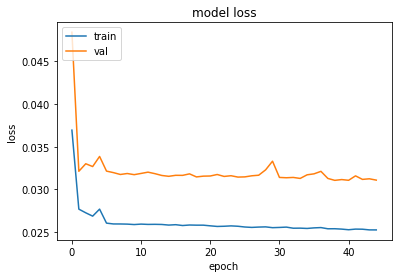

284/284 [==============================] - 2s 6ms/step


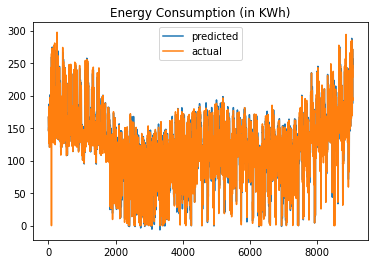

1102/1102 - 6s - loss: 0.0281 - 6s/epoch - 6ms/step


0.028097130358219147

In [75]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()


model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

284/284 [==============================] - 2s 6ms/step


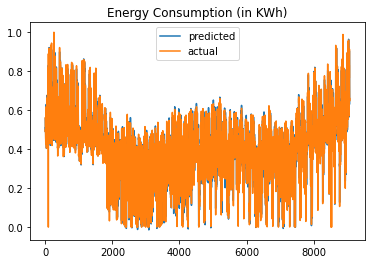

1102/1102 - 6s - loss: 0.0278 - 6s/epoch - 6ms/step


0.027805082499980927

In [21]:
tsf.data_train[0].shape

(9075, 21, 1)

In [55]:
tsf.inverse_scale_transform(model.predict(tsf.data_test[0]))

35/35 [==============================] - 0s 5ms/step


array([[157.01097],
       [150.53659],
       [147.78261],
       ...,
       [135.5795 ],
       [140.22096],
       [136.52733]], dtype=float32)

## Normalizer

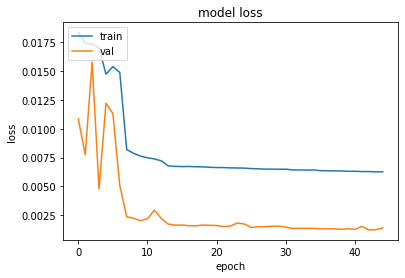

284/284 [==============================] - 2s 6ms/step


AttributeError: 'Normalizer' object has no attribute 'inverse_transform'

In [72]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

## StandardScaler

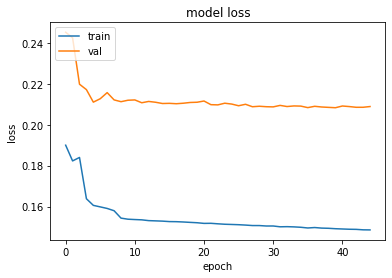

284/284 [==============================] - 2s 6ms/step


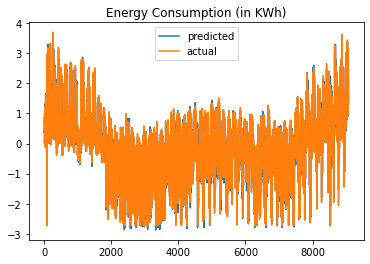

1102/1102 - 6s - loss: 0.1942 - 6s/epoch - 6ms/step


0.1942327469587326

In [61]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = model.predict(tsf.data_train[0])

y_label = tsf.data_train[1]
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

##  RobustScaler

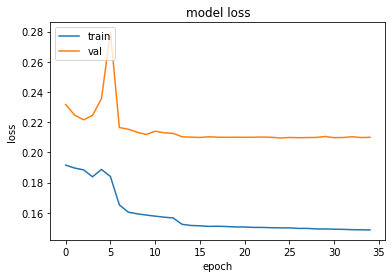

284/284 [==============================] - 2s 6ms/step


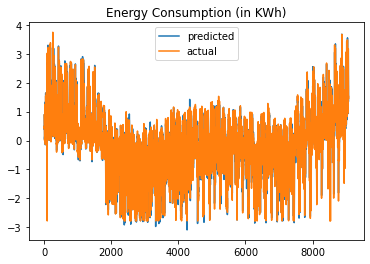

1102/1102 - 6s - loss: 0.1972 - 6s/epoch - 6ms/step


0.19718390703201294

In [64]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = model.predict(tsf.data_train[0])

y_label = tsf.data_train[1]
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

## PowerTransformer

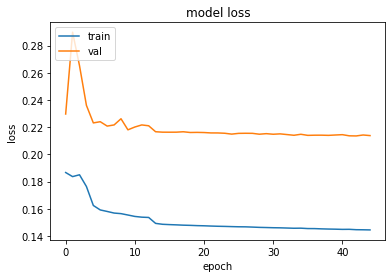

284/284 [==============================] - 1s 5ms/step


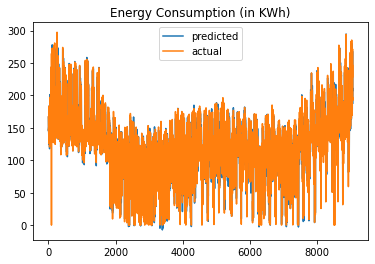

1102/1102 - 6s - loss: 0.1942 - 6s/epoch - 6ms/step


0.19420656561851501

In [69]:
# summarize history for loss
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

p = tsf.inverse_scale_transform(model.predict(tsf.data_train[0]))

y_label = tsf.inverse_scale_transform(tsf.data_train[1])
plt.plot(p)
plt.plot(y_label)
plt.title('Energy Consumption (in KWh)')
plt.legend(['predicted', 'actual'])
plt.show()

model.evaluate(tsf.data_test[0],tsf.data_test[1], batch_size=1,
               verbose=2,
               use_multiprocessing=True)

In [68]:
tsf.inverse_scale_transform(model.predict(tsf.data_test[0]))

35/35 [==============================] - 0s 6ms/step


array([[157.24965],
       [151.2192 ],
       [148.37784],
       ...,
       [136.00615],
       [138.16951],
       [135.4349 ]], dtype=float32)

# Run with LSTM model

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import Sequential
from keras.layers import Dense, LSTM

model_tsf = Sequential()
model_tsf.add(LSTM(200, return_sequences=True, activation='relu',
              input_shape=(tsf.data_train[0].shape[1], 1)))
model_tsf.add(LSTM(150))
model_tsf.add(Dense(7))

print(model_tsf.summary())
model_tsf.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
]

history_tsf = model_tsf.fit(x=tsf.data_train[0],
                            y=tsf.data_train[1],
                            epochs=100, validation_data=tsf.data_valid,
                            batch_size=32,
                            steps_per_epoch=100,
                            callbacks=callbacks)

2022-06-12 12:06:34.325216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-12 12:06:34.877988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1350 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:a1:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 21, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 150)               210600    
                                                                 
 dense (Dense)               (None, 7)                 1057      
                                                                 
Total params: 373,257
Trainable params: 373,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100


2022-06-12 12:06:37.347873: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-06-12 12:06:37.347928: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at cudnn_rnn_ops.cc:1553 : UNKNOWN: Fail to find the dnn implementation.


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm_1/PartitionedCall]] [Op:__inference_train_function_4376]